# Idea

Predict returns from prices and volume traded at previous periods using various models.

- Consider predicting log returns (i.e. log (p_2 / p_1)) using logs of input prices and volumes as well as prices and volumes themselves

# Imports

In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from ipynb.fs.full.utility_functions import (
    get_price_data,
    get_binance_px,
    get_train_test_data,
)
from datetime import datetime

# Get Historical Data For Cryptocurrencies

In [61]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

# px = get_price_data(univ, '4h', False, './class_project_input_prices.csv')
# px

In [62]:
# popular_univ = univ[["BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT"]]

In [63]:
from binance.client import Client as bnb_client

client = bnb_client(tld='US')
px = {}
freq = '4h'

univ = ["BTCUSDT"]

for coin in univ:
    print(f"Downloading data for symbol {coin}")
    data = get_binance_px(client, coin, freq)
    px[coin] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)

In [64]:
px

,BTCUSDT
open_time,
2020-12-20 00:00:00,23353.97
2020-12-20 04:00:00,23604.24
2020-12-20 08:00:00,23549.50
2020-12-20 12:00:00,23880.85
2020-12-20 16:00:00,23932.71
...,...
2025-11-09 04:00:00,101750.00
2025-11-09 08:00:00,102322.17
2025-11-09 12:00:00,103812.12


predict close price for row (t, t+1) from:

- (t-1, t): open, high, low, close, volume, quote_volume, num_trades, taker_base_volume, taker_quote_volume, trade hour
- (t-2, t-1): open, high, low, close, volume, quote_volume, num_trades, taker_base_volume, taker_quote_volume, trade hour
- (t-3, t-2): ...
- (t-7, t-6): ... (for seasonality of a day)

In [65]:
def construct_look_back_data(input_data):
    input_data = input_data.drop(columns=["ignore"])
    input_data.set_index('open_time', inplace=True)
    input_data["period_return"] = input_data["close"].astype(float) / input_data["close"].astype(float).shift() - 1
    
    raw_input_data_back_1 = input_data.rename(columns=lambda x: x + "_back_1").shift()
    raw_input_data_back_2 = input_data.rename(columns=lambda x: x + "_back_2").shift(2)
    raw_input_data_back_3 = input_data.rename(columns=lambda x: x + "_back_3").shift(3)
    raw_input_data_back_6 = input_data.rename(columns=lambda x: x + "_back_6").shift(6)
    
    merged_input_data = pd.concat(
        [raw_input_data_back_1, raw_input_data_back_2, raw_input_data_back_3, raw_input_data_back_6], axis=1
    )
    
    original_input_columns = [
        "open", "high", "low", "close", "volume", "quote_volume", "num_trades", "taker_base_volume",
        "taker_quote_volume", "period_return",
    ]

    new_input_columns = [
        *map(lambda x: x + "_back_1", original_input_columns),
        *map(lambda x: x + "_back_2", original_input_columns),
        *map(lambda x: x + "_back_3", original_input_columns),
        *map(lambda x: x + "_back_6", original_input_columns),
    ]
    
    input_x = merged_input_data[new_input_columns]
    input_x["open_hour"] = input_x.index.hour
    input_x = input_x.astype(float)
    input_x = input_x.loc[~np.isnan(input_x).any(axis=1)]
    
    y = input_data["period_return"].loc[input_x.index]
    
    return input_x, y


def construct_log_look_back_data(input_data):
    input_data = input_data.drop(columns=["ignore", "close_time"])
    input_data.set_index('open_time', inplace=True)
    log_input_data = np.log(input_data.astype(float))
    log_input_data = log_input_data.rename(columns=lambda x: "log_" + x)
    
    log_input_data["log_return"] = np.log(input_data["close"].astype(float) / input_data["close"].astype(float).shift())
    
    log_raw_input_data_back_1 = log_input_data.rename(columns=lambda x: x + "_back_1").shift()
    log_raw_input_data_back_2 = log_input_data.rename(columns=lambda x: x + "_back_2").shift(2)
    log_raw_input_data_back_3 = log_input_data.rename(columns=lambda x: x + "_back_3").shift(3)
    log_raw_input_data_back_6 = log_input_data.rename(columns=lambda x: x + "_back_6").shift(6)
    
    merged_log_input_data = pd.concat([
        log_raw_input_data_back_1, log_raw_input_data_back_2, log_raw_input_data_back_3,
        log_raw_input_data_back_6
    ], axis=1)
    
    original_input_columns = [
        "log_open", "log_high", "log_low", "log_close", "log_volume", "log_quote_volume", "log_num_trades",
        "log_taker_base_volume", "log_taker_quote_volume", "log_return",
    ]

    new_input_columns = [
        *map(lambda x: x + "_back_1", original_input_columns),
        *map(lambda x: x + "_back_2", original_input_columns),
        *map(lambda x: x + "_back_3", original_input_columns),
        *map(lambda x: x + "_back_6", original_input_columns),
    ]
    
    input_x = merged_log_input_data[new_input_columns]
    input_x["open_hour"] = input_x.index.hour
    input_x = input_x.astype(float)
    input_x = input_x.loc[~np.isnan(input_x).any(axis=1)]
    
    y = log_input_data["log_return"].loc[input_x.index]
    
    return input_x, y

In [66]:
all_x, all_y = construct_look_back_data(data)

t = datetime(2024, 1, 1, 0, 0)

train_x, test_x = get_train_test_data(all_x, t)
train_y, test_y = get_train_test_data(all_y, t)

/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_3099/3243504692.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_x["open_hour"] = input_x.index.hour


In [67]:
import statsmodels.api as sm
import numpy as np

train_x = sm.add_constant(train_x)
model = sm.OLS(train_y, train_x)
model

In [68]:
results = model.fit()
results.params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


const                        1.258418e-03
open_back_1                  1.159774e-05
high_back_1                  9.436773e-08
low_back_1                   5.459281e-07
close_back_1                -2.112234e-06
volume_back_1                2.185433e-05
quote_volume_back_1         -4.668048e-10
num_trades_back_1            1.828596e-08
taker_base_volume_back_1    -4.251484e-05
taker_quote_volume_back_1    9.032085e-10
period_return_back_1         2.878830e-02
open_back_2                  3.914917e-06
high_back_2                  5.995974e-08
low_back_2                   3.620014e-07
close_back_2                -9.174358e-06
volume_back_2                1.461919e-05
quote_volume_back_2          2.849348e-10
num_trades_back_2           -6.508250e-08
taker_base_volume_back_2    -3.109425e-05
taker_quote_volume_back_2   -5.359334e-10
period_return_back_2        -2.424560e-02
open_back_3                  2.182827e-06
high_back_3                  2.368924e-07
low_back_3                  -5.320

In [69]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          period_return   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.321
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           3.82e-06
Time:                        17:28:02   Log-Likelihood:                 18876.
No. Observations:                6633   AIC:                        -3.767e+04
Df Residuals:                    6591   BIC:                        -3.738e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0013      0.001      1.462      0.144      -0.000       0.003
open_back_1                 1.16e-05   8.15e-06      1.423      0.155   -4.37e-06    2.76e-05
high_back_1                9.437e-08   1.29e-07      0.734      0.463   -1.58e-07    3.46e-07
low_back_1                 5.459e-07   6.68e-07      0.817      0.414   -7.63e-07    1.86e-06
close_back_1              -2.112e-06   1.19e-06     -1.779      0.075   -4.44e-06    2.15e-07
volume_back_1              2.185e-05    3.7e-05      0.591      0.554   -5.06e-05    9.43e-05
quote_volume_back_1       -4.668e-10   1.08e-09     -0.431      0.667   -2.59e-09    1.66e-09
num_trades_back_1          1.829e-08   1.28e-07      0.143      0.887   -2.33e-07    2.69e-07
taker_base_volume_back_1  -4.251e-05   7.47e-05     -0.569      0.569      -0.000       0.000
taker_quote_volume_back_1  9.032e-10   2.16e-09      0.419      0.676   -3.33e-09    5.13e-09
period_return_back_1          0.0288      0.043      0.664      0.507      -0.056       0.114
open_back_2                3.915e-06   8.11e-06      0.483      0.629    -1.2e-05    1.98e-05
high_back_2                5.996e-08   1.29e-07      0.466      0.641   -1.92e-07    3.12e-07
low_back_2                  3.62e-07   6.65e-07      0.544      0.586   -9.41e-07    1.67e-06
close_back_2              -9.174e-06   8.38e-06     -1.095      0.273   -2.56e-05    7.25e-06
volume_back_2              1.462e-05   3.71e-05      0.394      0.693    -5.8e-05    8.73e-05
quote_volume_back_2        2.849e-10   1.09e-09      0.261      0.794   -1.85e-09    2.42e-09
num_trades_back_2         -6.508e-08   1.42e-07     -0.458      0.647   -3.44e-07    2.13e-07
taker_base_volume_back_2  -3.109e-05   7.49e-05     -0.415      0.678      -0.000       0.000
taker_quote_volume_back_2 -5.359e-10   2.16e-09     -0.248      0.804   -4.78e-09    3.71e-09
period_return_back_2         -0.0242      0.043     -0.558      0.577      -0.109       0.061
open_back_3                2.183e-06   1.16e-06      1.889      0.059   -8.19e-08    4.45e-06
high_back_3                2.369e-07   1.29e-07      1.843      0.065   -1.51e-08    4.89e-07
low_back_3                 -5.32e-07   6.51e-07     -0.818      0.413   -1.81e-06    7.43e-07
close_back_3              -7.565e-06   8.32e-06     -0.909      0.363   -2.39e-05    8.75e-06
volume_back_3              2.529e-06   3.69e-05      0.068      0.945   -6.98e-05    7.49e-05
quote_volume_back_3       -4.127e-10   1.08e-09     -0.381      0.703   -2.54e-09    1.71e-09
num_trades_back_3         -5.461e-08   1.29e-07     -0.424      0.672   -3.07e-07    1.98e-07
taker_base_volume_back_3  -1.224e-05   7.43e-05     -0.165      0.869      -0.000       0.000
taker_quote_volume_back_3  1.363e-09   2.15e-09      0.634      0.526   -2.

In [70]:
test_x = sm.add_constant(test_x)
predicted_test_y = model.predict(results.params, test_x)
predicted_test_y

array([-0.00090643, -0.00110783, -0.00094586, ..., -0.00093173,
       -0.00399452, -0.00420468])

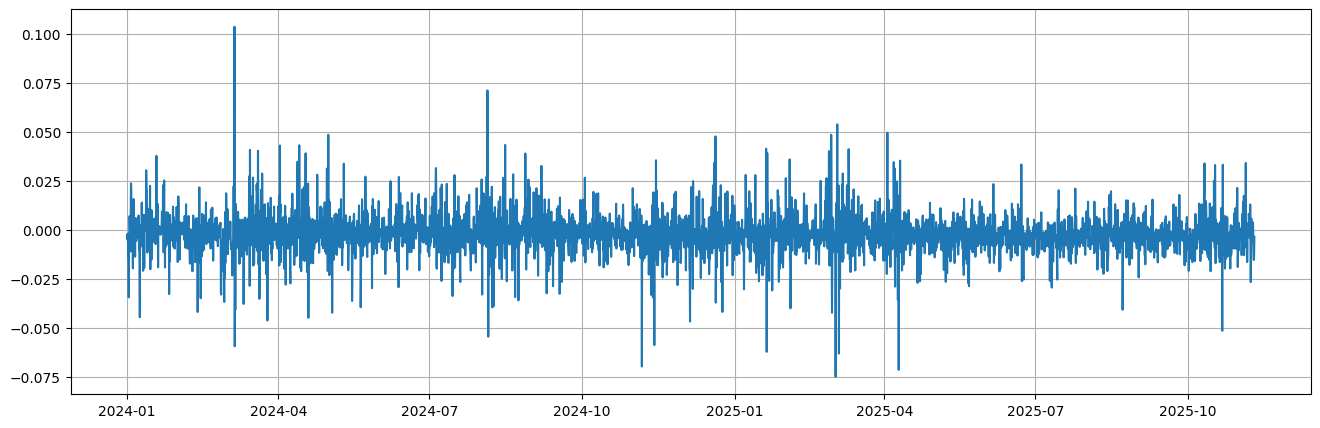

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))
plt.plot(pd.Series(predicted_test_y - test_y, index=test_x.index))
plt.grid()
plt.show()

# With Only Log Values

In [38]:
all_x, all_y = construct_look_back_data(data)

t = datetime(2024, 1, 1, 0, 0)

# train_x, test_x = get_train_test_data(all_x, t)
# train_y, test_y = get_train_test_data(all_y, t)

/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_3099/3324583286.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_x["open_hour"] = input_x.index.hour


In [55]:
log_inputs, log_returns = construct_log_look_back_data(data)

train_x, test_x = get_train_test_data(log_inputs, t)
train_y, test_y = get_train_test_data(log_returns, t)

In [57]:
import statsmodels.api as sm
import numpy as np

train_x = sm.add_constant(train_x)
model = sm.OLS(train_y, train_x)
model

In [58]:
results = model.fit()
results.params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


const                            0.011525
log_open_back_1                  0.635019
log_high_back_1                  0.004754
log_low_back_1                  -0.038538
log_close_back_1                -0.273958
log_volume_back_1               -0.077162
log_quote_volume_back_1          0.076895
log_num_trades_back_1            0.000543
log_taker_base_volume_back_1    -0.002062
log_taker_quote_volume_back_1    0.001296
log_return_back_1                0.208992
log_open_back_2                  0.254444
log_high_back_2                 -0.011823
log_low_back_2                   0.004128
log_close_back_2                -0.482950
log_volume_back_2                0.322623
log_quote_volume_back_2         -0.321753
log_num_trades_back_2           -0.000067
log_taker_base_volume_back_2    -0.350630
log_taker_quote_volume_back_2    0.349802
log_return_back_2                0.081917
log_open_back_3                  0.452020
log_high_back_3                  0.061228
log_low_back_3                   0

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     2.857
Date:                Sun, 09 Nov 2025   Prob (F-statistic):           8.41e-09
Time:                        17:25:53   Log-Likelihood:                 18884.
No. Observations:                6633   AIC:                        -3.769e+04
Df Residuals:                    6593   BIC:                        -3.742e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0115      0.007      1.587      0.113      -0.003       0.026
log_open_back_1                   0.6350      0.334      1.903      0.057      -0.019       1.289
log_high_back_1                   0.0048      0.014      0.337      0.736      -0.023       0.032
log_low_back_1                   -0.0385      0.032     -1.217      0.223      -0.101       0.024
log_close_back_1                 -0.2740      0.105     -2.618      0.009      -0.479      -0.069
log_volume_back_1                -0.0772      0.230     -0.336      0.737      -0.528       0.373
log_quote_volume_back_1           0.0769      0.230      0.335      0.738      -0.374       0.527
log_num_trades_back_1             0.0005      0.001      0.676      0.499      -0.001       0.002
log_taker_base_volume_back_1     -0.0021      0.235     -0.009      0.993      -0.462       0.458
log_taker_quote_volume_back_1     0.0013      0.235      0.006      0.996      -0.459       0.462
log_return_back_1                 0.2090      0.103      2.032      0.042       0.007       0.411
log_open_back_2                   0.2544      0.333      0.764      0.445      -0.399       0.908
log_high_back_2                  -0.0118      0.014     -0.838      0.402      -0.039       0.016
log_low_back_2                    0.0041      0.032      0.129      0.897      -0.059       0.067
log_close_back_2                 -0.4829      0.206     -2.348      0.019      -0.886      -0.080
log_volume_back_2                 0.3226      0.230      1.404      0.160      -0.128       0.773
log_quote_volume_back_2          -0.3218      0.230     -1.400      0.162      -0.772       0.129
log_num_trades_back_2         -6.654e-05      0.001     -0.075      0.940      -0.002       0.002
log_taker_base_volume_back_2     -0.3506      0.235     -1.494      0.135      -0.811       0.110
log_taker_quote_volume_back_2     0.3498      0.235      1.490      0.136      -0.110       0.810
log_return_back_2                 0.0819      0.196      0.418      0.676      -0.302       0.466
log_open_back_3                   0.4520      0.333      1.356      0.175      -0.201       1.106
log_high_back_3                   0.0612      0.014      4.332      0.000       0.034       0.089
log_low_back_3                    0.0393      0.031      1.263      0.207      -0.022       0.100
log_close_back_3                 -0.5649      0.307     -1.840      0.066      -1.167       0.037
log_volume_back_3                -0.5412      0.230     -2.358      0.018      -0.991      -0.091
log_quote_volume_back_3           0.5438      0.230      2.368      0.018       0.094       0.994
log_num_trades_back_3            -0.0009      0.001     -1.146      0.252      -0.003       0.001
log_taker_base_volume_back_3      0.7406     